# Bitcoin analysis and forecast based on historical trade data

### Readme

This is a test for me to get started with FB Prophet. The prediction and forecast is just for testing and should not be taken seriously. Of course, if the prediction and forecast is correct, I'll take all the honor and glory and you should hire me as a great data analyst. However, the analysis shows some interesting stuff nonetheless.


The trade data is from 2011-01-06 to 2018-03-03.

Processing all data resulted in a memory error. The forecast with with cleaned up respective all data is significant. In addition, please note that the source and downloaded data is already not complete and shows some gaps like this one:

```
...
1512463918,9000.000000000000,0.147381890000
1512463920,9000.000000000000,0.001753960000 <--- Tue Dec 05 2017 09:52
1513354573,14000.000000000000,0.001000000000 <--- Fri Dec 15 2017 17:16
1513355093,14000.000000000000,0.001000000000
...
```

If anybody knows a source where I can find complete data without gaps or has an idea for the reason of the gaps please give me a hint.

The prediction and forecast is for one year. 

We should check back latest 2019-03-03 to see if the forecast was correct and to make a new one ;)

### Resources
#### Prophet
https://research.fb.com/prophet-forecasting-at-scale/
#### Bitcoin trade history CSV (I used the € data BTW)
http://api.bitcoincharts.com/v1/csv/

In [1]:
import warnings
import datetime
import pandas as pd
from fbprophet import Prophet

warnings.filterwarnings('ignore')

def dateparse (time_in_secs):    
    dt = datetime.datetime.fromtimestamp(float(time_in_secs))
    return dt.replace(hour=0, minute=0, second=0, microsecond=0)

df = pd.read_csv('bitcoin_trade_history.csv' ,parse_dates=['ds'], date_parser=dateparse, usecols=['ds', 'y'])
df.head()

,ds,y
0,2011-01-06,0.24990
1,2011-01-06,0.25499
2,2011-01-06,0.25499
3,2011-01-10,0.27100
4,2011-01-12,0.26000


Next we consolidate the dates and find the highest trade for the day

In [2]:
dates = [ ]
high_values = [ ]
dates.append(df['ds'][0])
high_values.append(df['y'][0])
for x in range(1, len(df['ds'])):
    if (df['ds'][x] > dates[len(dates)-1]):
        dates.append(df['ds'][x])
        high_values.append(df['y'][x])
    elif (df['y'][x] > high_values[len(dates)-1]):
        high_values[len(dates)-1] = df['y'][x]
               
dfc = pd.DataFrame({'ds': dates,'y': high_values})
dfc.head()

,ds,y
0,2011-01-06,0.25499
1,2011-01-10,0.27100
2,2011-01-12,0.26000
3,2011-01-13,0.28519
4,2011-01-14,0.29900


In [3]:
m = Prophet(daily_seasonality=False)
m.fit(dfc)
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2612,2019-02-25
2613,2019-02-26
2614,2019-02-27
2615,2019-02-28
2616,2019-03-01


In [4]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2612,2019-02-25,15717.096865,14192.911956,17108.730666
2613,2019-02-26,15736.982273,14328.381242,17018.354114
2614,2019-02-27,15763.978108,14361.575474,17057.003022
2615,2019-02-28,15781.768964,14356.396105,17282.480927
2616,2019-03-01,15827.051125,14357.473196,17151.308336


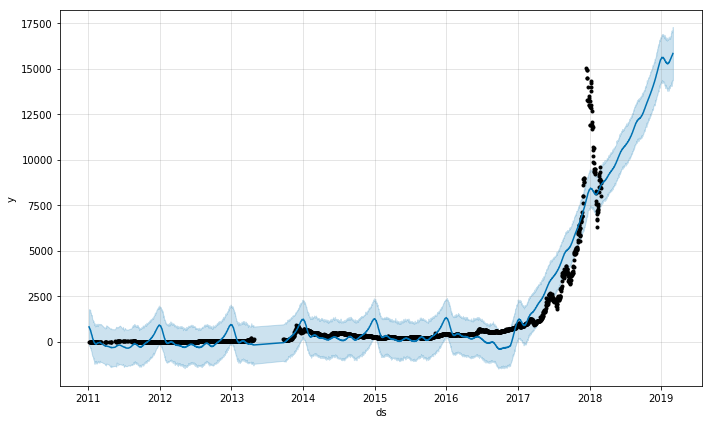

In [5]:
m.plot(forecast);

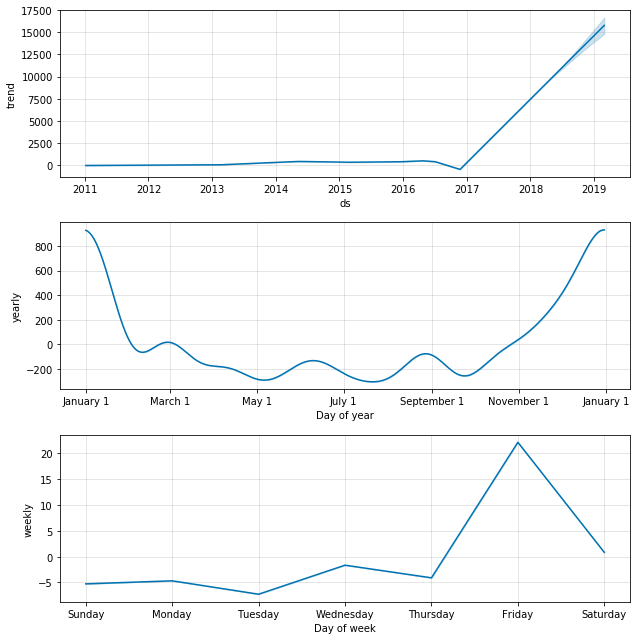

In [6]:
m.plot_components(forecast);

We take all transaction data starting late November...

In [7]:
dfc_f20k = df[-20000:]
dfc_f20k.head()

,ds,y
272424,2017-11-24,6850.00
272425,2017-11-24,6850.00
272426,2017-11-24,6756.01
272427,2017-11-24,6850.00
272428,2017-11-24,6849.99


...and do a shorter, 60 days forecast

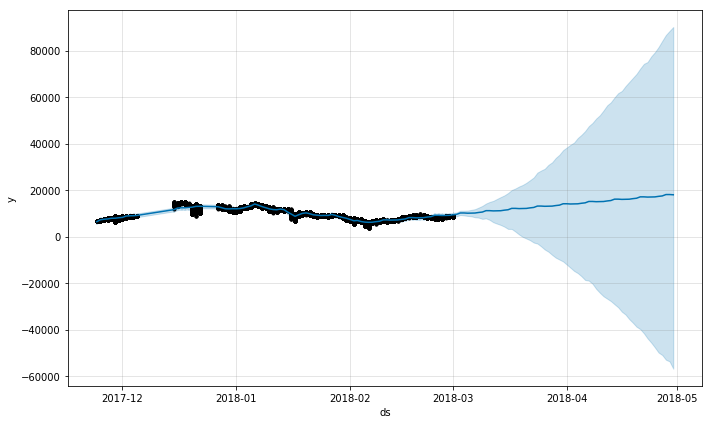

In [8]:
m_f20k = Prophet(daily_seasonality=False, yearly_seasonality=False)
m_f20k.fit(dfc_f20k)
future_f20k = m_f20k.make_future_dataframe(periods=60)
forecast_f20k = m_f20k.predict(future_f20k)
m_f20k.plot(forecast_f20k);

Now let's assume that the end of 2017 run was an outlier. We remove the outlier and see how the forecast changes

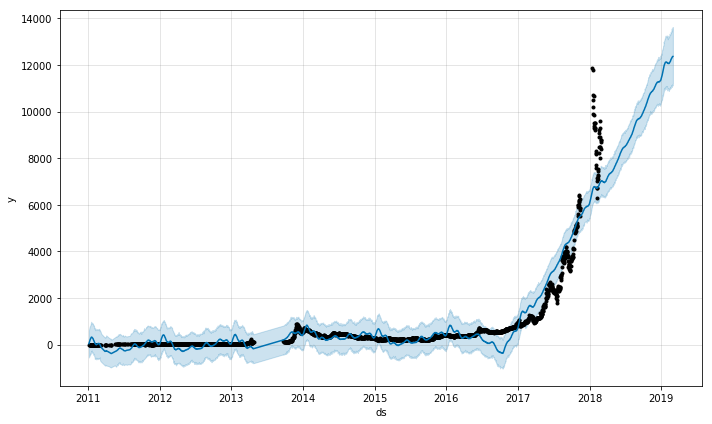

In [9]:
outlier_from = pd.Timestamp('2017-11-15')
outlier_to = pd.Timestamp('2018-01-15')
for x in range(0, len(dates)-1):
    if (dates[x] > outlier_from and dates[x] < outlier_to):
        high_values[x] = None
mwo = Prophet(daily_seasonality=False)
dfc_wo = pd.DataFrame({'ds': dates,'y': high_values})
mwo.fit(dfc_wo)
future_wo = mwo.make_future_dataframe(periods=365)
forecast_without_outliers = mwo.predict(future_wo)
mwo.plot(forecast_without_outliers);

And because it's easy we plot again based on the cleaned up data to see the differences

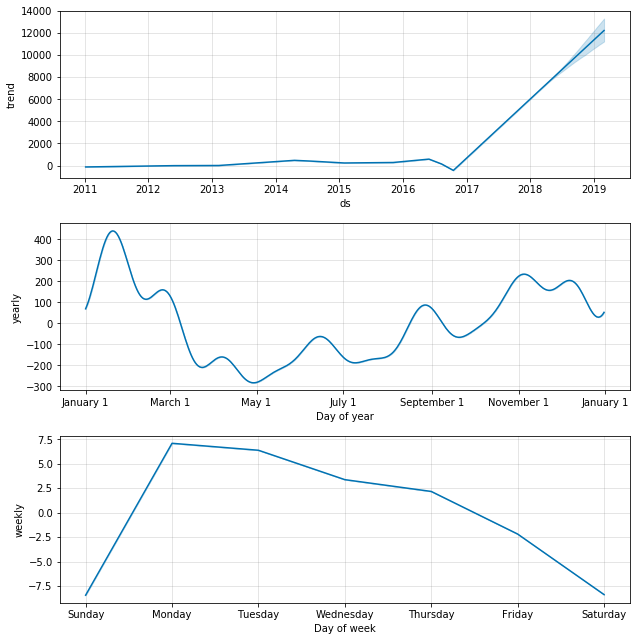

In [10]:
mwo.plot_components(forecast_without_outliers);